# Monte Carlo Radiative Transfer

Running this notebook requires https://github.com/JuliaLang/IJulia.jl which prerequisites:
- Python
- Pip
- Jupyter notebook
- Julia

All code is written by scratch, inspired by the repo https://github.com/unoebauer/mcrtreview-tools. All theory is summarized from "Monte Carlo Radiative Transfer" by Noebauer and Sim.
## Background

### Important Variables

- Specific Intensity $I_v$ or $I(\mathbf{x}, t, \nu)$
- $\mathbf{x}$ position in space
- $\mu$ propagation direction
- $t$ time
- $\nu$ frequency
- $\chi_a$ absorption coefficient
- $\chi_s$ scattering coefficient
- $\chi_t = \chi_a + \chi_s$ total extinction coefficient or opacity

The radiative transfer equation describes the propagation of light through a medium. Let us start by assuming the light propagates through empty space then

$$
\frac{dI_v}{ds} = 0
$$

where $I$ is the intensity of light and $s$ is the distance traveled. Let us add a radiation absorbing medium to the mix. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v
$$

where $\alpha$ is the *fractioanl depletion coefficient* per path length. We can define the optical depth $\tau$ as

$$
d \tau_v = -\alpha_v ds
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = -I_v
$$

However radiation can also travel through a radiation emitting medium. The radiative transfer equation then becomes

$$
\frac{dI_v}{ds} = -\alpha_v I_v + j_v
$$

where $j$ is the *emission coefficient*. We can also define it in terms of the optical depth

$$
\frac{dI_v}{d\tau_v} = \frac{j_v}{\alpha_v} - I_v.
$$

We then define the source function as 

$$
S_v = \frac{j_v}{\alpha_v}
$$

and the radiative transfer equation becomes

$$
\frac{dI_v}{d\tau_v} = S_v - I_v.
$$

## MCRT 

We can simulate the radiative transfer equation using Monte Carlo methods. We leverage an abstraction called photon packets, or machine photons, where a number of photons are grouped together. The photons are described by their position, direction, frequency, energy and weight. Over the course of the simulation, each photon packet continously accumulates optical depth. Hence contrary to classical simulations, we do not integrate over time but over optical depth.



We treat interactions with the medium as discrete interaction events, hence the MC algorithm needs to find when those events occur. We denote a random number as $\xi$. At the beginning of each packet trajectory event, each packet is assigned a new optical depth distance to the next interaction by

$$
\tau = -\log(\xi)
$$

we then compute the length of the path in physical space by dividing the optical depth by the total extinction coefficient $\chi_a$

$$
l = \frac{\tau}{\chi_a}
$$

or if we include scattering

$$
l = \frac{\tau}{\chi_t}.
$$

We can then update the position of the photon packet by

$$
\mathbf{x} = \mathbf{x} + l \mathbf{\mu}
$$

where $\mathbf{\mu}$ is the direction of the photon packet. For the case of pure absorption, the packet is absorbed and the simulation ends. If we include scattering, we need to determine if the photon packet is scattered which happens when

$$
\xi \leq \frac{\chi_s}{\chi_t}
$$

where $\xi$ is a random number between 0 and 1. If the photon packet is scattered, we need to draw a new direction for the photon packet

$$
\mathbf{\mu} = \xi - 1.
$$

## Julia implementation

Let us now implement the above with Julia

In [1]:
using Plots

First we create a new data structure which stores the Photon Packets data. 

In [2]:
# We define the Photon Packets
mutable struct PP
    # position in optical depth space
    x::AbstractArray{Float64, 1}
    # propagation direction, lengthless
    mu::AbstractArray{Float64, 1}
    # energy 
    E::AbstractArray{Float64, 1}
    # state of the packet, False means the photon has escaped
    absorbed::AbstractArray{Bool, 1}
    escaped::AbstractArray{Bool, 1}
end

In [3]:
function rand_range(type::Type{T}, N::Int, a::T, b::T)::AbstractArray{T, 1} where T
    return rand(type, N) .* (b .- a) .+ a
end

rand_range (generic function with 1 method)

We then code the event function, which is responsible to update the states of all photon packets at any moment in time. We implement it right away with a scattering and non scattering version. 

In [4]:
mutable struct Params
    # uniform temperature of the medium
    T::Float64
    # scattering coefficient
    chi_scattering::Float64
    # absorbtion coefficient
    chi_absorbtion::Float64
    # radius of the sphere in m
    radius::Float64
    # number of packets
    N::Int
    # density sampling function
    density::Function
    # enable scattering -> Drawing new directions
    enable_scattering::Bool
    # radiation constant, J m^-3 K^-4
    C::Float64
end

function event!(pp::PP, params::Params)::Nothing

    N = size(pp.x)[1]

    # sample optical depth to next event
    tau_to_next = -log.(rand(Float64, N))

    # set chi total / opacity 
    chi_tot = params.chi_absorbtion
    if params.enable_scattering
        chi_tot += params.chi_scattering
    end
    
    # Invert the optical depth to get the phyiscal distance
    l_to_next = tau_to_next ./ chi_tot

    # Update the state of the packets
    pp.x .+= l_to_next .* pp.mu

    # Decide if packets crossed boundaries
    escaped = (pp.x .> params.radius) .|| (pp.x .< -params.radius)

    # Update the escape state of the packets
    pp.escaped = pp.escaped .|| (escaped .&& .!pp.absorbed)

    # Decide if packets are scattered or absorbed 
    if params.enable_scattering
        is_scattered = rand(N) .< (params.chi_scattering / chi_tot)
        # Update the scatter state of the packets
        pp.absorbed = pp.absorbed .|| (.!is_scattered .&& .!pp.escaped)
        # Scatter the packets -> Draw new propagation directions            
        pp.mu = rand_range(Float64, N, -1.0, 1.0)
    else
        # in the absorbtion only case, all packets which do not escape are absorbed
        # code in if scope would behave the same way
        pp.absorbed = .!pp.escaped
    end

    return nothing
end

event! (generic function with 1 method)

Now we implement the entire MRCT simulation. 

In [5]:
function mcrt!(
        packets :: PP,
        params :: Params) :: Nothing

    # Loop over packets until all are absorbed or have escaped
    while !all((packets.absorbed .|| packets.escaped))
        # print("number of packets: ", size(packets.x)[1], "\n")
        # print("number of absorbed packets: ", sum(packets.absorbed), "\n")
        # print("number of escaped packets: ", sum(packets.escaped), "\n")
        # print(packets.x, "\n")
        event!(packets, params)
        # print("number of absorbed packets: ", sum(packets.absorbed), "\n")
        # print("number of escaped packets: ", sum(packets.escaped), "\n")
    end

    return nothing
end

mcrt! (generic function with 1 method)

## Sampling from density profile B

We are given the function 
$$
f(r) = \frac{1}{(r + \delta)^2}.
$$
To sample from the function we to find the inverse of the Integral. Therefore we start with the integral
$$
F(r) = -\frac{1}{r + \delta}
$$
then we invert the function and get
$$
F^{-1} = \delta \frac{1}{r}.
$$
We can now plug in a random distribution as $r$ to sample from the density profile function $f(r)$. We can verify this visually:

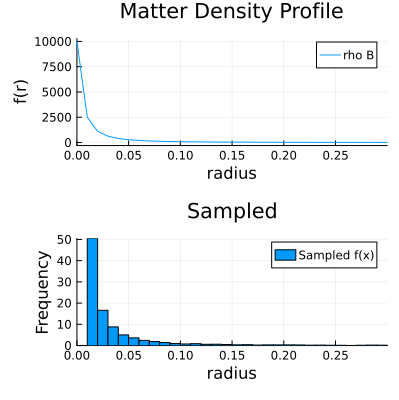

In [6]:
delta = 0.01
profile_B = x -> 1 ./ (x .+ delta).^2
sample_B = x -> delta .* 1 ./ x
sample_A = x -> x

x = 0:0.01:1
y = profile_B(x)

# two plots with shared x-axis
p1 = plot(x, y, label="rho B", xlabel="radius", ylabel="f(r)", title="Matter Density Profile", xlim=(0, 0.3))

x = rand(Float64, 10000)
y = sample_B(x)

bins = 0:0.01:1
p2 = histogram(y, label="Sampled f(x)", xlabel="radius", ylabel="Frequency", title="Sampled", xlim=(0, 0.3), normalize=:pdf, bins=bins)

plot(p1, p2, layout=(2, 1), legend=true, size=(400, 400))

## Sampling from a Sphere

In [7]:
function sample_from_sphere(radius::Float64, N::Int64)::AbstractArray{Float64, 1}
    # Same formula if oparating in optical depth or physical space
    sample = rand_range(Float64, N, -1.0, 1.0)
    uniform_radius = radius .* abs.(sample).^(1. ./ 3.) .* sign.(sample)

    return uniform_radius
end

sample_from_sphere (generic function with 1 method)

Lets test the sampling. Note that we except a sparser density of points in the central area in the case of the uniform sampling A. This is due to the 2d projection.

In [78]:
function plot_x(x::AbstractArray{Float64, 1})::Plots.Plot
    N = size(x)[1]
    angle = rand_range(Float64, N, 0.0, 2.0 * pi)

    return plot(
        x .* cos.(angle), 
        x .* sin.(angle), 
        seriestype = :scatter, 
        aspect_ratio = 1, 
        xlim=(-1.1, 1.1),
        ylim=(-1.1, 1.1),
        markersize = 1,
        markershape = :circle,
        markercolor = :black,
        markerstrokewidth = 0,
        label = "Packet Position")
end

plot_x (generic function with 1 method)

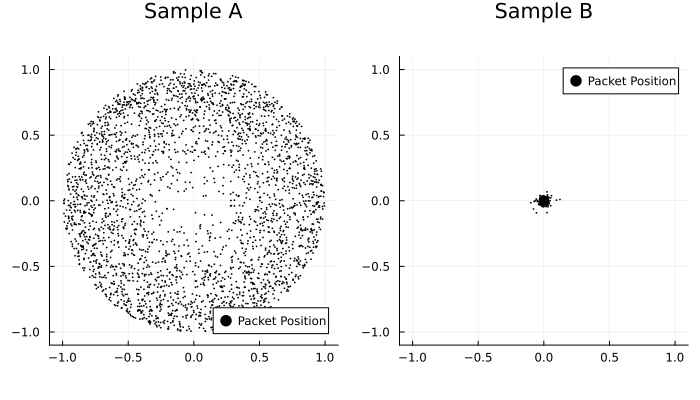

In [79]:
N = 3000
x = sample_from_sphere(1.0, N)
x = sample_A(x)

p1 = plot_x(x)
# set title and labels
title!("Sample A")

x = sample_B(x)

p2 = plot_x(x)

title!("Sample B")

plot(p1, p2, layout=(1, 2), legend=true, size=(700, 400))



With this working, we implement a function to initialize all photon packets.

In [80]:
function init_packets(params::Params)::PP

    # Compute the sphere volume
    volume = 4/3 * pi * params.radius^3.0
    return PP(
        # sample position from the density profile
        params.density(sample_from_sphere(params.radius, params.N)),
        # initial velocity is randomly distributed between -1 and 1. 
        # Note that we could in principle leverage the sphere symmetry
        rand_range(Float64, params.N, -1.0, 1.0),
        # initial energy in Joules 
        ones(Float64, params.N) .* params.C .* params.T.^4.0 .* volume ./ params.N,
        # all packets start as not absorbed and not escaped
        zeros(Bool, params.N),
        zeros(Bool, params.N))
end

init_packets (generic function with 1 method)

In [81]:
function init_run_mcrt(params :: Params) :: PP

    packets = init_packets(params)
    mcrt!(packets, params)
    return packets
    
end

init_run_mcrt (generic function with 1 method)

Let us what happens visually.

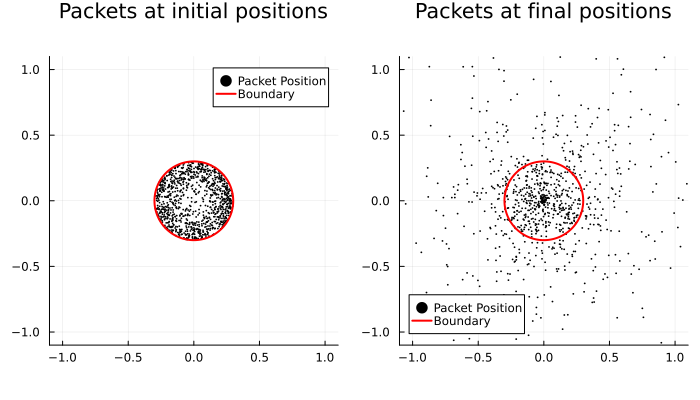

In [90]:
boundary_radius = 0.3
params = Params(1.0, 0.0, 1.0, boundary_radius, 1000, sample_A, false, 5.67e-8)

packets = init_packets(params)

p1 = plot_x(packets.x)
# add cirlce to plot
x = cos.(0:0.01:2*pi) .* boundary_radius
y = sin.(0:0.01:2*pi) .* boundary_radius
plot!(x, y, color=:black, linewidth=2, label="Boundary", linecolor=:red)
# set title and labels
title!("Packets at initial positions")

mcrt!(packets, params)

p2 = plot_x(packets.x)
plot!(x, y, color=:black, linewidth=2, label="Boundary", linecolor=:red)
title!("Packets at final positions")

plot(p1, p2, layout=(1, 2), legend=true, size=(700, 400))


## Task 1: Escape probability

Escape probability without scattering. First we include the analytic solution from the reference implemenation.

In [91]:
function p_esc_analytic(t::Float64)::Float64
    """Calculate the escape probability analytically

    Note: it is assumed that there is no scattering within the sphere, but
    that photons/packets can only be absorbed.

    """
    return (3. / (4. * t) * (1. - 1. / (2. * t^2) + (1. / t + 1. / (2. * t^2)) * exp(-2. * t)))

end

p_esc_analytic (generic function with 1 method)

In [92]:
resolution = 15
n_packets = 20000

# J m^-3 K^-4, source: https://scienceworld.wolfram.com/physics/RadiationConstant.html
radiation_constant :: Float64 = 7.5657e-16

chi_absorbtion = 0.9
temperature = 1.0

esc_prob_A = zeros(resolution)
esc_prob_B = zeros(resolution)
esc_prob_analytic = zeros(resolution)

optical_depth = 10.0.^LinRange(-2, 2, resolution)

params = Params(
    temperature, # temperature of medium
    0,  # scattering
    chi_absorbtion,
    0, # radius
    n_packets,
    sample_A, # density Function
    false, # disabled scattering
    radiation_constant)

for i in 1:resolution

    # println("Optical depth: ", optical_depth[i], "\n")
    # println("Radius: ", radius[i], "\n")

    params.radius = optical_depth[i] / chi_absorbtion
    params.density = sample_A
    
    packets_A = init_run_mcrt(params)
    esc_prob_A[i] = sum(packets_A.escaped) / n_packets

    params.density = sample_B
    packets_B = init_run_mcrt(params)
    esc_prob_B[i] = sum(packets_B.escaped) / n_packets

    esc_prob_analytic[i] = p_esc_analytic(optical_depth[i])
end


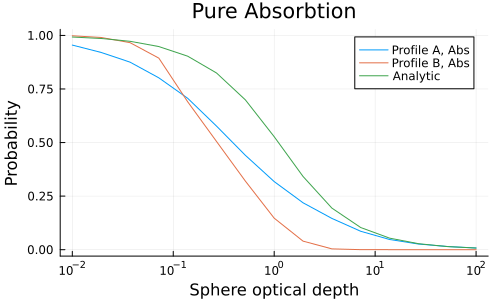

In [96]:
# x axis in log
plot(optical_depth, esc_prob_A, xaxis=:log, label="Profile A, Abs", size=(500, 300))
plot!(optical_depth, esc_prob_B, xaxis=:log, label="Profile B, Abs")
plot!(optical_depth, esc_prob_analytic, xaxis=:log, label="Analytic", 
    xlabel="Sphere optical depth", ylabel="Escape Probability", title="Escape Probability")   
# add x and y labels
xlabel!("Sphere optical depth")
ylabel!("Probability")
# add title 
title!("Pure Absorbtion")

## Energy Flux

One part of the task is to find the energy flux of the sphere, as a function of optical depth.
To do so, we need to know the amount of energy a photon packet has stored. 

In [146]:
resolution = 15
n_packets = 20000

# J m^-3 K^-4, source: https://scienceworld.wolfram.com/physics/RadiationConstant.html
radiation_constant :: Float64 = 7.5657e-16

chi_absorbtion = 0.1
temperature = 1000000

energy_flux_A = zeros(resolution)
energy_flux_B = zeros(resolution)
esc_prob_analytic = zeros(resolution)

optical_depth = 10.0.^LinRange(-2, 2, resolution)

params = Params(
    temperature, # temperature of medium
    0,  # scattering
    chi_absorbtion,
    0, # radius
    n_packets,
    sample_A, # density Function
    false, # disabled scattering
    radiation_constant)

for i in 1:resolution

    # println("Optical depth: ", optical_depth[i], "\n")
    # println("Radius: ", radius[i], "\n")

    params.radius = optical_depth[i] / chi_absorbtion
    params.density = sample_A
    
    packets = init_packets(params)
    total = sum(packets.E)
    mcrt!(packets, params)
    esc_prob = sum(packets.escaped) / n_packets
    energy_flux_A[i] = total * esc_prob 

    println("esc_prob   : ", esc_prob, "\n")
    println("energy total  : ", total, "\n")

    params.density = sample_B
    packets = init_packets(params)
    total = sum(packets.E)
    mcrt!(packets, params)
    esc_prob = sum(packets.escaped) / n_packets
    energy_flux_B[i] = total * esc_prob

    println("esc_prob   : ", esc_prob, "\n")

end

energy_flux_A .+= 0.001
energy_flux_B .+= 0.001


esc_prob   : 0.9535

energy total  : 3.169113005235244e6

esc_prob   : 0.96115

esc_prob   : 0.918

energy total  : 2.280765225989426e7

esc_prob   : 0.91545

esc_prob   : 0.87475

energy total  : 1.641434056623823e8

esc_prob   : 0.86055

esc_prob   : 0.7998

energy total  : 1.1813165737283287e9

esc_prob   : 0.77735

esc_prob   : 0.7051

energy total  : 8.501766133910869e9

esc_prob   : 0.6618

esc_prob   : 0.58105

energy total  : 6.11859928178206e10

esc_prob   : 0.5002

esc_prob   : 0.44055

energy total  : 4.403468241933683e11

esc_prob   : 0.3146

esc_prob   : 0.3172

energy total  : 3.1691130052352397e12

esc_prob   : 0.1449

esc_prob   : 0.2176

energy total  : 2.280765225989427e13

esc_prob   : 0.04105

esc_prob   : 0.14695

energy total  : 1.6414340566238278e14

esc_prob   : 0.00415

esc_prob   : 0.08795

energy total  : 1.1813165737283288e15

esc_prob   : 0.0

esc_prob   : 0.04985

energy total  : 8.501766133910856e15

esc_prob   : 0.0

esc_prob   : 0.02675

energy total  :

15-element Vector{Float64}:
 3.045992965981855e6
 2.0879265262320198e7
 1.412536077437631e8
 9.182964385887164e8
 5.626468827423214e9
 3.0605233607474865e10
 1.3853311089123468e11
 4.592044744585872e11
 9.362541252686608e11
 6.811951334988895e11
 0.001
 0.001
 0.001
 0.001
 0.001

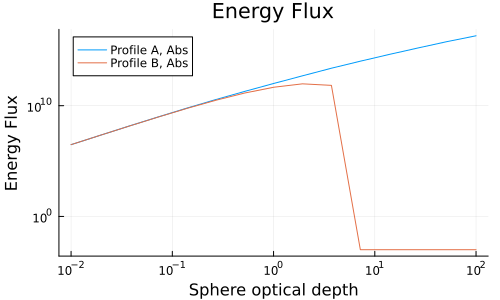

In [147]:
# x axis in log
plot(optical_depth, energy_flux_A, xaxis=:log, yaxis=:log, label="Profile A, Abs", size=(500, 300))
plot!(optical_depth, energy_flux_B, xaxis=:log, yaxis=:log, label="Profile B, Abs")
# set legend position
plot!(legend=:topleft)
# add x and y labels
xlabel!("Sphere optical depth")
ylabel!("Energy Flux")
# add title
title!("Energy Flux")